# Transfer learning d'un modèle de détection d'images

L'une des petites révolutions que le Deep Learning a permis est le fait de pouvoir entraîner des modèles sur des __données très volumineuses__. En particulier, les modèles de détection d'images, les _Convolutional Neural Networks (CNN)_ ont pu se développer.  
Ces modèles s'appuient sur des couches profondes spécifiques : __les réseaux convolutifs__. Ceux-ci permettent de pré-traiter les images afin de repérer des structures spécifiques dans les images et de pouvoir ainsi correctement les classifier, en évitant le [sur-apprentissage](https://blog.statoscop.fr/le-dilemme-biais-variance-dans-la-modelisation-de-donnees.html#liens-avec-loverfitting-et-lunderfitting-dans-les-modeles-de-machine-learning). Ces couches de convolution sont suivis de réseaux de neurones classiques permettant d'obtenir la classification voulue.   
Reste que ces modèles doivent être entraînés sur des quantités importantes de données avant d'être performants, et que cet entraînement peut être extrêmement long et coûteux en ressources, rendant quasi-impossible le fait de le réaliser sur son ordinateur en local. C'est là qu'intervient le __transfer learning__. Le principe est de partir d'un modèle pré-entraîné et de se contenter de le ré-entraîner ou d'en entraîner une partie sur ses données spécifiques. En particulier, la partie _convolution_ du modèle n'est pas spécifique à un thème donné et n'a souvent pas besoin d'être ré-entraîné. C'est comme si on se contentait de _spécialiser_ un modèle généraliste. Cette méthode va nous permettre de gagner un temps précieux en entraînement et de bénéficier de performances de modèles entraînés sur un grand nombre de données.  
Voyons comment la mettre en oeuvre avec la __librairie Python `keras`__.


# Préparation des données  
Pour notre exemple, on va partir ici d'un [dataset Kaggle](https://www.kaggle.com/datasets/maysee/mushrooms-classification-common-genuss-images/data) avec des images de différents types de champignons.  
Avec `keras`, **le dataset est créé directement à partir d'un dossier** où chaque sous-dossier comporte une classe, qui sera labellisée par le nom de celui-ci. De plus, la **partition entre données d'entraînement et de validation** peut être faite directement à ce moment là. On utilise pour cela la fonction `image_dataset_from_directory`, avec les paramètres correspondant à notre problème.  
On a aussi **créé en amont un dossier contenant un sous-ensemble de ces images** qui nous servira de **dataset de test** au moment de l'évaluation de notre modèle.


In [1]:
IMG_SIZE = 256

from keras.utils import image_dataset_from_directory  
images_dataset = image_dataset_from_directory('dataset', # nom du dossier où se trouvent mes deux dossiers d'images
                                              batch_size = 64, # Nombre d'images chargées simultanément en mémoire lors de l'apprentissage
                                              image_size = (IMG_SIZE, IMG_SIZE), # Choix du taille de l'image
                                              validation_split = 0.30, # 30% des données en set de validation
                                              seed = 15, # reproductibilité du split aléatoire
                                              label_mode = "categorical", # problème de classif
                                              subset = "both") # on crée les deux sets d'entraînement et de validation
training_set = images_dataset[0]
validation_set = images_dataset[1]

# Set test 
test_set = image_dataset_from_directory('Set test', # nom du dossier où se trouvent mes deux dossiers d'images
                                        image_size = (IMG_SIZE, IMG_SIZE), # Choix de la taille de l'image
                                        label_mode = "categorical") # problème de classif

2024-02-12 11:23:50.219924: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-12 11:23:50.264476: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 11:23:50.264501: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 11:23:50.268310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 11:23:50.279091: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-12 11:23:50.279883: I tensorflow/core/platform/cpu_feature_guard.cc:1

Found 5372 files belonging to 9 classes.
Using 3761 files for training.
Using 1611 files for validation.
Found 1339 files belonging to 9 classes.


Nos images ont bien été chargées, nous pouvons vérifier que les labels ont été correctement attribuées : 

In [2]:
training_set.class_names

['Agaricus',
 'Amanita',
 'Boletus',
 'Cortinarius',
 'Entoloma',
 'Hygrocybe',
 'Lactarius',
 'Russula',
 'Suillus']

À noter qu'il est importer de correctement paramétrer la __taille du batch__ et les __dimensions de l'image__. Plus la taille du batch est importante, plus le modèle tournera rapidement, mais il pourrait être moins précis et surtout votre machine pourrait crasher par manque de RAM et/ou GPU. Pour la taille de l'image, de la même manière elle aura **un impact sur les performances du modèle** et sur la capacité de votre machine à encaisser l'entraînement.

# Entraînement du modèle  
Pour entraîner notre modèle, on commence par charger un des modèles de détection d'images disponibles dans `keras` puis on définit l'ensemble de notre réseau de neurones.  

## Chargement d'un modèle pré-entraîné  
De nombreux **modèles CNN pré-entraînés** peuvent être chargés depuis `keras`. Ils sont répertoriés sur [cette page](https://keras.io/api/applications/) de la documentation. Nous décidons pour notre exemple d'utiliser __le modèle Xception__ :  



In [3]:
# Chargement du modèle Xception
from keras.applications import ResNet50V2
classifier_resnet = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

Notez que l'on paramétrise `include_top=False` de manière à pouvoir choisir le format de nos images en entrée, ici en X*X.  
Le modèle chargé a la structure suivante :  

In [4]:
classifier_resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

On constate qu'il contient de nombreuses couches et donc de nombreux paramètres à entraîner. Pour optimiser le temps d'exécution, on décide de ne pas ré-entraîner ces paramètres :  

In [5]:
# On définit les couches cachées comme non entraînables
#(on pourrait les réentrainer ou choisir de ne réentrainer que les premières par exemple)
for layer in classifier_resnet.layers:
    layer.trainable = False

## Structure de notre modèle  
Il ne nous reste plus qu'à **introduire ce bloc convolutif dans notre réseau de neurones**. On y ajoute en amont des couches permettant d'appliquer une mise à l'échelle uniforme (`Rescaling`) et des modifications des images en entrée (`RandomRotation`, `RandomFlip`) permettant d'obtenir un **modèle plus généralisable** En sortie du modèle Xception, **on ajoute une couche `Flatten()`** permettant d'obtenir un vecteur de données issues du traitement de convolution, puis **quelques couches de réseau de neurones** qui serviront à entraîner notre modèle sur nos données.  
On choisit ici d'ajouter X couches `Dense` de X et X neurones. Les nombres de couches et de neurones que vous allez implémenter dépendent de **la complexité du modèle souhaitée et de la taille des données d'entraînement dont vous disposez**. Il y a un arbitrage à faire entre [performances du modèle et risques de surapprentissage](https://blog.statoscop.fr/le-dilemme-biais-variance-dans-la-modelisation-de-donnees.html). Nous intercalons entre ces couches de neurones des couches de normalisation des batchs (`BatchNormalization`) qui jouent un rôle de régularisation et permettent justement de limiter les risques de surapprentissage. En sortie, la dernière couche doit avoir un **nombre de neurones égal au nombre de classes** de votre problème et une **fonction d'activation** correspondant à un problème de classification (ici `softmax`).   

In [31]:
from keras.models import Sequential
from keras.layers import Rescaling, RandomRotation, RandomFlip, RandomTranslation, RandomZoom, Flatten, Dropout, Dense, BatchNormalization
from keras.optimizers import Adam

# On définit l'ensemble de notre réseau
classifier_resnet_final = Sequential([
    Rescaling(1./255),
    RandomRotation(0.2),
    RandomFlip("horizontal_and_vertical"),
    RandomTranslation((-0.3, 0.3), (-0.3, 0.3)),
    RandomZoom((0, 0.3)),
    classifier_resnet,
    Flatten(),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(9, activation='softmax')
])

# On compile avec l'algorithme d'optimisation, la fonction de perte et la métrique en sortie : 
classifier_resnet_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Enfin, il ne nous reste plus qu'à lancer **l'entraînement de notre modèle sur nos données**. En amont, on crée un `ModelCheckPoint` qui va permettre de sauvegarder sur notre disque le modèle le plus performant :  

In [32]:
# On fait un modèle check point
from keras.callbacks import ModelCheckpoint
model_checkpoint_callback = ModelCheckpoint(
    filepath="model/best.keras",
    save_weights_only=False,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')

On lance finalement l'entraînement, en choisissant __X epochs__. Les époques sont **le nombre de fois où chaque point sera vu par le modèle**. La taille du __batch__ correspond au nombre d'images dans chaque lot de données qui sera envoyé dans le modèle avant mise à jour de ses paramètres. Elle a été définie dans la fonction `image_dataset_from_directory` et est de 64 images. Cela signifie que ma machine doit pouvoir supporter de charger 64 images en mémoire. Pour chaque époque, il y a donc X étapes, ou passages de batch, permettant que l'ensemble des images des données d'entraînement soit vu par le modèle.

In [ ]:
# On lance l'entraînement 
fitting_resnet = classifier_resnet_final.fit(
    training_set,
    epochs = 20,
    validation_data = validation_set,
    callbacks=[model_checkpoint_callback]) 

Epoch 1/20
59/59 [==============================] - 420s 7s/step - loss: 1.9753 - accuracy: 0.3581 - val_loss: 2.2584 - val_accuracy: 0.4643
Epoch 2/20
59/59 [==============================] - 398s 7s/step - loss: 1.5187 - accuracy: 0.4786 - val_loss: 1.5036 - val_accuracy: 0.5320
Epoch 3/20
59/59 [==============================] - 406s 7s/step - loss: 1.3815 - accuracy: 0.5185 - val_loss: 1.3690 - val_accuracy: 0.5556
Epoch 4/20
59/59 [==============================] - 430s 7s/step - loss: 1.2880 - accuracy: 0.5602 - val_loss: 1.2357 - val_accuracy: 0.5934
Epoch 5/20
59/59 [==============================] - 480s 8s/step - loss: 1.2177 - accuracy: 0.5642 - val_loss: 1.2076 - val_accuracy: 0.6046
Epoch 6/20
59/59 [==============================] - 421s 7s/step - loss: 1.1674 - accuracy: 0.5959 - val_loss: 1.1844 - val_accuracy: 0.6189
Epoch 7/20
59/59 [==============================] - 398s 7s/step - loss: 1.1595 - accuracy: 0.5826 - val_loss: 1.1701 - val_accuracy: 0.6182
Epoch 8/20
59

# Évaluation et utilisation du modèle  
Une fois le modèle entraîné, il faut évaluer ses performances avant de l'utiliser pour réaliser de nouvelles prédictions.  

## Évaluation du modèle avec `scikit-learn` 

On utilise enfin notre set de test, importé au début de cet article en même temps que les sets d'entraînement de validation. En effet, si le modèle n'a pas été entraîné à proprement parler sur le set de validation, ce dernier a __servi à sélectionner le modèle final durant l'entraînement__ et n'est donc pas adapté pour en fournir une évaluation non biaisée. On évalue donc maintenant les performances du modèle finalement sélectionné, qui avait obtenu une accuracy de X% sur les données de validation, avec les données test. 
On propose ici une **méthode pour utiliser les fonctions `classification_report` et `confusion_matrix` de `scikit-learn`** sur un modèle `keras`.  

In [16]:
import numpy as np
from sklearn.metrics import classification_report
from keras.saving import load_model

modele_resnet = load_model("model/best.keras")

# on prédit sur le set de validation et on attribue la classe correspondant
# à la plus grande probabilité
predict_test = modele_resnet.predict(test_set)
predictions = np.argmax(predict_test, axis = -1)
# on récupère ensuite la vraie valeur depuis le set_test
true_values =  np.array([])
for x, y in test_set:
  true_values = np.concatenate([true_values, np.argmax(y.numpy(), axis=-1)])

42/42 [==============================] - 101s 2s/step


In [30]:
print(predict_test, predictions)


[[2.8788962e-04 5.8511650e-05 1.4855152e-03 ... 5.9735034e-02
  8.8864064e-05 9.2707300e-01]
 [2.2503559e-06 1.8085621e-04 2.2551340e-04 ... 3.2061223e-05
  9.9844098e-01 6.4913795e-05]
 [9.4783376e-04 6.6162273e-03 5.9832772e-03 ... 1.5244594e-01
  8.3003342e-01 7.6850323e-04]
 ...
 [5.4782017e-06 1.2824225e-05 7.7414807e-05 ... 1.2393252e-01
  1.4816353e-03 6.2377866e-02]
 [3.3790711e-01 1.1850316e-02 6.6881955e-02 ... 5.0667543e-03
  5.0347471e-01 4.9728882e-03]
 [9.1755368e-02 2.3998819e-02 1.7028786e-05 ... 3.6798215e-01
  1.3636583e-01 3.8522822e-04]] [8 7 7 ... 5 7 6]


In [28]:

np.unique(predictions, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([ 63, 164, 240, 131,  55,  59, 334, 240,  53]))

In [29]:
test_set.class_names

['Agaricus',
 'Amanita',
 'Boletus',
 'Cortinarius',
 'Entoloma',
 'Hygrocybe',
 'Lactarius',
 'Russula',
 'Suillus']

In [17]:
print(classification_report(y_true = true_values, y_pred = predictions, target_names = test_set.class_names))

              precision    recall  f1-score   support

    Agaricus       0.06      0.06      0.06        70
     Amanita       0.12      0.13      0.13       150
     Boletus       0.13      0.14      0.14       214
 Cortinarius       0.14      0.11      0.12       167
    Entoloma       0.07      0.06      0.06        72
   Hygrocybe       0.02      0.02      0.02        63
   Lactarius       0.27      0.29      0.28       312
     Russula       0.19      0.20      0.20       229
     Suillus       0.08      0.06      0.07        62

    accuracy                           0.16      1339
   macro avg       0.12      0.12      0.12      1339
weighted avg       0.16      0.16      0.16      1339



Le rapport de classification de scikit-learn est un bon instrument d'évaluation car il permet de voir de manière synthétique les forces et faiblesses du modèle. En particulier, pour chaque classe, il donne :  
- la **précision** du modèle, qui permet de voir, pour l'ensemble des prédictions d'une classe, la part qui appartenait bien à cette classe.
- le **rappel** du modèle, qui permet de voir, pour l'ensemble des images d'une classe, la part ayant été correctement prédite.
   
Il faut viser d'avoir les **meilleures performances possible sur ces deux indicateurs**. En effet, un modèle **très précis sur une classe**, c'est à dire dont les prédictions de cette classe sont souvent correctes, peut avoir malgré tout un **très mauvais rappel**, c'est à dire _manquer_ beaucoup d'images de cette classe en les prédisant à tort comme appartenant à d'autres classes.    

Par exemple, blablabla

On peut également compléter cette analyse avec une matrice de confusion : 

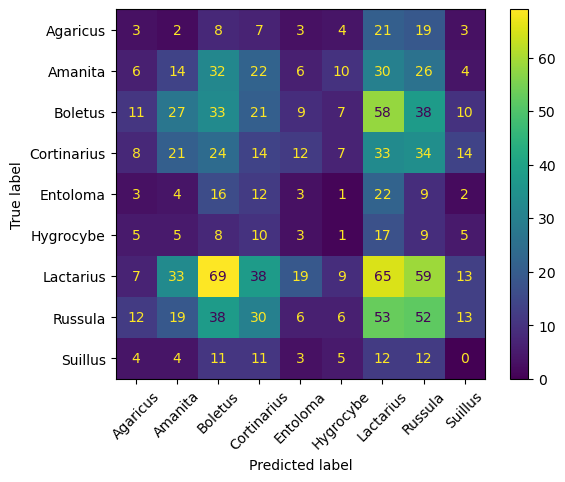

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 

cm = confusion_matrix(true_values, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels = test_set.class_names)
cmd.plot()
plt.xticks(rotation=45)
plt.show()


## Prédictions sur des nouvelles images

On propose enfin une méthode pour afficher la prédiction sur une nouvelle image. Il est en effet nécessaire de charger l'image mais aussi de la modifier pour qu'elle corresponde aux fonctions de `keras`. Voici comment :  

In [ ]:
from keras import utils
# chargement de l'image à la taille correspondante
image = utils.load_img("camera/champ1.jpg", target_size = (IMG_SIZE, IMG_SIZE))
# transformation en matrice de pixels 
image_array = utils.img_to_array(image)
# ajout d'une dimension pour simuler la matrice d'images
image_array2 = np.expand_dims(image_array, axis = 0)

# prédiction
prediction = modele_xception.predict(image_array2)

La prédiction est un vecteur de probabilités, on crée la valeur correspondant à la probabilité et le label pour ensuite pouvoir afficher ces informations au moment de la prédiction :  

In [ ]:
# la proba max
proba = np.max(prediction).round(2)
# l'index de la classe associée
index = np.argmax(prediction)
# le label de la classe prédite
label = test_set.class_names[index]
print(proba, label)

Il n'y a plus qu'à afficher l'image chargée et la prédiction associée, par exemple en la mettant en forme sous forme de titre `matplotlib` :  

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
img = np.asarray(Image.open('camera/champ1.jpg'))
plt.title("Notre modèle prédit que c'est un champignon "+label+" avec une probabilité de "+str(proba))
plt.imshow(img)
plt.axis('off')
plt.show()

Et voilà! Il ne vous reste plus qu'à mettre tout ça dans une fonction et à l'intégrer... à votre [application Flask](https://flask.palletsprojects.com/en/3.0.x/) par exemple! Promis on vous explique comment faire tout ça très rapidement.  

C'est tout pour aujourd'hui! N'hésitez pas à [visiter notre site](https://www.statoscop.fr) et à nous suivre sur [Twitter](https://twitter.com/stato_scop) et [Linkedin](https://www.linkedin.com/company/statoscop). Pour retrouver le code ayant servi à générer cette note, vous pouvez vous rendre sur le [github de Statoscop](https://github.com/Statoscop/notebooks-blog). 

In [ ]:
# Bonus : code permettant de cleaner le format des images
from struct import unpack
import os


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        

for sousdir in os.listdir("dataset"):
    for img in os.listdir("dataset/"+sousdir):
      image = "dataset/"+sousdir+"/"+img
      image = JPEG(image) 
      try:
        image.decode()   
      except:
        bads.append(img)
        for name in bads:
          os.remove("dataset/"+sousdir+"/"+name)